In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the license plate image
img = cv2.imread('UKLicencePlateDataset/whiteplate_normal/AA03BOJ.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

<h2>USING DEEP LEARNING OCR METHODE</h2>

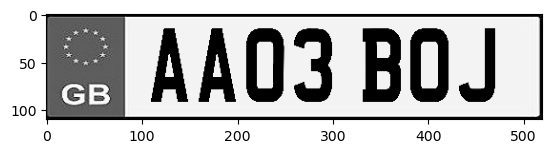

In [2]:
plt.imshow(gray,cmap='gray' )

In [3]:
#Maximize Contrast

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

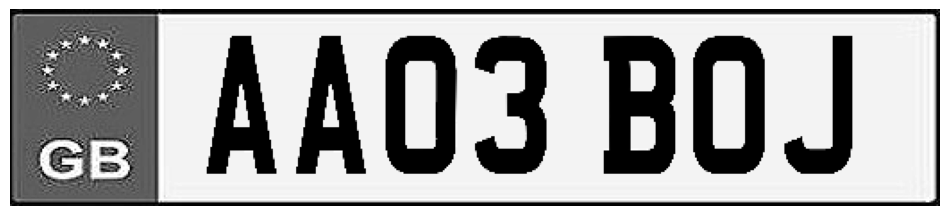

In [4]:

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('Car-Contrast.png',bbox_inches = 'tight')
plt.show()

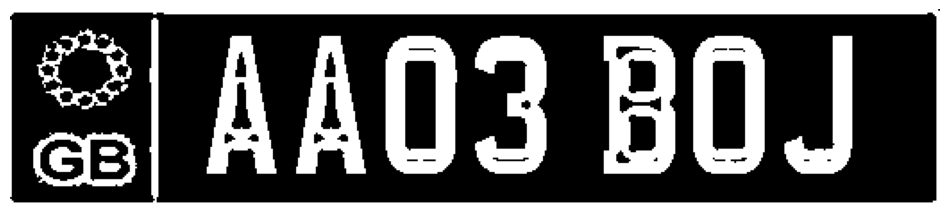

In [5]:
#Adaptive Thresholding

img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')
plt.axis('off')
#plt.savefig('Car-Adaptive-Thresholding.png',bbox_inches = 'tight')
plt.show()

In [6]:
height, width, channel = img.shape

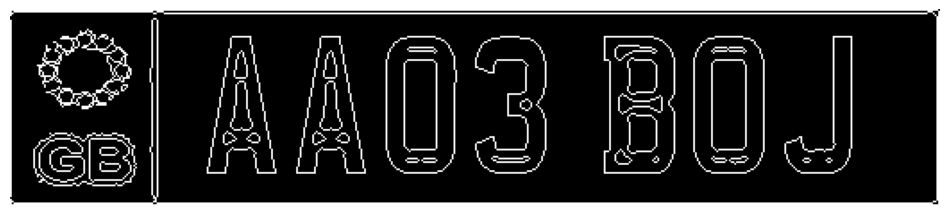

In [7]:
#Finding Contours to locate plate

contours, _= cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)
plt.axis('off')
#plt.savefig('Car-Contours.png',bbox_inches = 'tight')
plt.show()

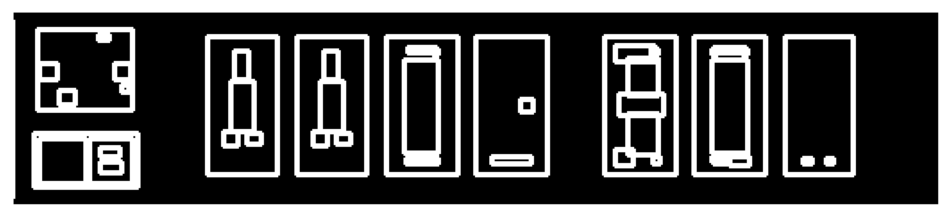

In [8]:
#Data Preparation

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
#plt.savefig('Car-Boxes.png',bbox_inches = 'tight')
plt.show()

In [9]:
#Selecting Boxes by Char Size

MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        

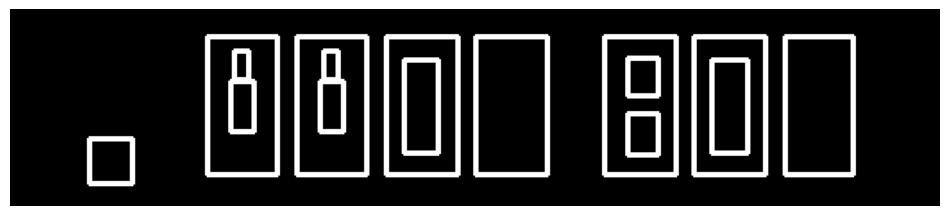

In [10]:
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#    cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('Car-Boxes-byCharSize.png',bbox_inches = 'tight')
plt.show()


In [11]:
#Selecting Boxes by Arrangement of Contours

MAX_DIAG_MULTIPLYER = 5 # 5
MAX_ANGLE_DIFF = 12.0 # 12.0
MAX_AREA_DIFF = 0.5 # 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3 # 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))


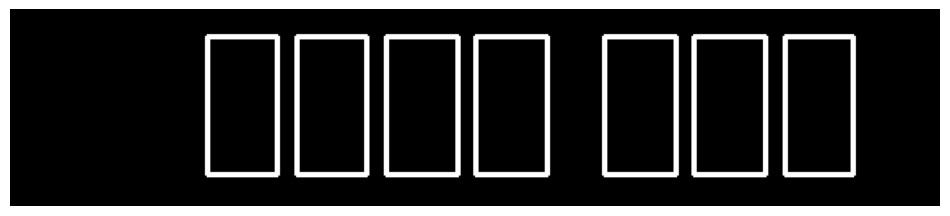

In [12]:

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
#plt.savefig('Car-Boxes-byContourArrangement.png',bbox_inches = 'tight')
plt.show()

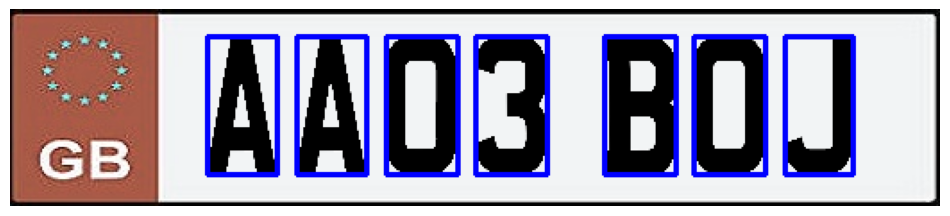

In [13]:

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(img, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(img, cmap='gray')
plt.axis('off')
#plt.savefig('Car-OverlappingBoxes.png',bbox_inches = 'tight')
plt.show()


In [25]:
import easyocr

reader = easyocr.Reader(['en'])

# Test EasyOCR on a sample image
image_path = 'UKLicencePlateDataset/whiteplate_augmented/AA20GFI.png'
results = reader.readtext(image_path)

# Find the longest recognized text
longest_text = ''
for result in results:
    text = result[1]  # Get the recognized text
    if len(text) > len(longest_text):
        longest_text = text

# Display only the characters with the longest recognized text
for result in results:
    text = result[1]  # Get the recognized text
    if text == longest_text:
        print(text)


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


AA2O GFI


In [15]:
import easyocr
import os

reader = easyocr.Reader(['en'])

image_dir = 'UKLicencePlateDataset/whiteplate_normal'  # Directory containing the images
max_images = 10  # Maximum number of images to process

for idx, image_name in enumerate(os.listdir(image_dir)):
    if idx >= max_images:
        break
    
    image_path = os.path.join(image_dir, image_name)
    expected_label = os.path.splitext(image_name)[0]  # Extract the label from the image filename
    
    results = reader.readtext(image_path)
    
    recognized_texts = [result[1] for result in results]  # Extract all recognized texts
    
    longest_text = max(recognized_texts, key=len)  # Select the longest recognized text
    
    print(f"Image: {image_name}")
    print(f"Expected Label: {expected_label}")
    print(f"Predicted Text: {longest_text}")
    print('---')


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Image: AA03BOJ.png
Expected Label: AA03BOJ
Predicted Text: AA03 BOJ
---
Image: AA06OHE.png
Expected Label: AA06OHE
Predicted Text: Aao6 OHE
---
Image: AA15VJJ.png
Expected Label: AA15VJJ
Predicted Text: AAI5 VJJ
---
Image: AA22JTE.png
Expected Label: AA22JTE
Predicted Text: AA22 JTE
---
Image: AA25WEI.png
Expected Label: AA25WEI
Predicted Text: AA25 HEI
---
Image: AA39HMS.png
Expected Label: AA39HMS
Predicted Text: Aa39 HMS
---
Image: AA61PSS.png
Expected Label: AA61PSS
Predicted Text: AAGI PSS
---
Image: AA67AAL.png
Expected Label: AA67AAL
Predicted Text: Aa67 AAL
---
Image: AA70PYY.png
Expected Label: AA70PYY
Predicted Text: AA7O PYY
---
Image: AA71THV.png
Expected Label: AA71THV
Predicted Text: AA7i THV
---


In [17]:
import easyocr
import os

reader = easyocr.Reader(['en'])

image_dir = 'UKLicencePlateDataset/whiteplate_normal'  # Directory containing the images
max_images = 10  # Maximum number of images to process

total_images = 0
correct_predictions = 0

for idx, image_name in enumerate(os.listdir(image_dir)):
    if idx >= max_images:
        break
    
    image_path = os.path.join(image_dir, image_name)
    expected_label = os.path.splitext(image_name)[0]  # Extract the label from the image filename
    
    results = reader.readtext(image_path)
    
    recognized_text = results[0][1] if results else ''  # Get the recognized text (assuming only one result)
    
    longest_text = ""
    current_text = ""
    for char in recognized_text:
        if char.isalpha():
            current_text += char
        elif current_text:
            if len(current_text) > len(longest_text):
                longest_text = current_text
            current_text = ""
    
    if len(current_text) > len(longest_text):
        longest_text = current_text
    
    # Remove any spaces from the longest recognized text
    longest_text = longest_text.replace(" ", "")
    
    if longest_text == expected_label:
        correct_predictions += 1
    
    total_images += 1

    print(f"Image: {image_name}")
    print(f"Expected Label: {expected_label}")
    print(f"Predicted Text: {longest_text}")
    print('---')

accuracy = correct_predictions / total_images * 100
print(f"Accuracy: {accuracy:.2f}%")


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Image: AA03BOJ.png
Expected Label: AA03BOJ
Predicted Text: GB
---
Image: AA06OHE.png
Expected Label: AA06OHE
Predicted Text: GB
---
Image: AA15VJJ.png
Expected Label: AA15VJJ
Predicted Text: GB
---
Image: AA22JTE.png
Expected Label: AA22JTE
Predicted Text: GB
---
Image: AA25WEI.png
Expected Label: AA25WEI
Predicted Text: GB
---
Image: AA39HMS.png
Expected Label: AA39HMS
Predicted Text: GB
---
Image: AA61PSS.png
Expected Label: AA61PSS
Predicted Text: GB
---
Image: AA67AAL.png
Expected Label: AA67AAL
Predicted Text: GB
---
Image: AA70PYY.png
Expected Label: AA70PYY
Predicted Text: GB
---
Image: AA71THV.png
Expected Label: AA71THV
Predicted Text: GB
---
Accuracy: 0.00%


In [22]:
import easyocr
import os

reader = easyocr.Reader(['en'])

image_dir = 'UKLicencePlateDataset/whiteplate_normal'  # Directory containing the images
max_images = 10  # Maximum number of images to process

total_images = 0
correct_predictions = 0

for idx, image_name in enumerate(os.listdir(image_dir)):
    if idx >= max_images:
        break
    
    image_path = os.path.join(image_dir, image_name)
    expected_label = os.path.splitext(image_name)[0]  # Extract the label from the image filename
    
    results = reader.readtext(image_path)
    
    recognized_texts = [result[1] for result in results]  # Extract all recognized texts
    
    longest_text = max(recognized_texts, key=len)  # Select the longest recognized text
    longest_text1 = longest_text.replace(" ", "")
    
    # Compare the predicted text and expected label (case insensitive)
    if longest_text1.lower() == expected_label.lower():
        correct_predictions += 1
    
    total_images += 1

    print(f"Image: {image_name}")
    print(f"Expected Label: {expected_label}")
    print(f"Predicted Text: {longest_text}")
    print('---')

accuracy = correct_predictions / total_images * 100
print(f"Accuracy: {accuracy:.2f}%")


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Image: AA03BOJ.png
Expected Label: AA03BOJ
Predicted Text: AA03 BOJ
---
Image: AA06OHE.png
Expected Label: AA06OHE
Predicted Text: Aao6 OHE
---
Image: AA15VJJ.png
Expected Label: AA15VJJ
Predicted Text: AAI5 VJJ
---
Image: AA22JTE.png
Expected Label: AA22JTE
Predicted Text: AA22 JTE
---
Image: AA25WEI.png
Expected Label: AA25WEI
Predicted Text: AA25 HEI
---
Image: AA39HMS.png
Expected Label: AA39HMS
Predicted Text: Aa39 HMS
---
Image: AA61PSS.png
Expected Label: AA61PSS
Predicted Text: AAGI PSS
---
Image: AA67AAL.png
Expected Label: AA67AAL
Predicted Text: Aa67 AAL
---
Image: AA70PYY.png
Expected Label: AA70PYY
Predicted Text: AA7O PYY
---
Image: AA71THV.png
Expected Label: AA71THV
Predicted Text: AA7i THV
---
Accuracy: 40.00%


In [28]:
import easyocr
import os
import random

reader = easyocr.Reader(['en'])

image_dir = 'UKLicencePlateDataset/yellowplate_normal'  # Directory containing the images
max_images = 100  # Maximum number of images to process

total_images = 0
correct_predictions = 0

image_list = os.listdir(image_dir)
selected_images = random.sample(image_list, max_images)

for image_name in selected_images:
    image_path = os.path.join(image_dir, image_name)
    expected_label = os.path.splitext(image_name)[0]  # Extract the label from the image filename
    
    results = reader.readtext(image_path)
    
    recognized_texts = [result[1] for result in results]  # Extract all recognized texts
    
    longest_text = max(recognized_texts, key=len)  # Select the longest recognized text
    longest_text1 = longest_text.replace(" ", "")
    
    # Compare the predicted text and expected label (case insensitive)
    if longest_text1.lower() == expected_label.lower():
        correct_predictions += 1
    
    total_images += 1

    #print(f"Image: {image_name}")
    #print(f"Expected Label: {expected_label}")
    #print(f"Predicted Text: {longest_text}")
    #print('---')

accuracy = correct_predictions / total_images * 100
print(f"Accuracy: {accuracy:.2f}%")


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Accuracy: 40.00%


In [30]:
import easyocr

reader = easyocr.Reader(['en'])

# Test EasyOCR on a sample image
image_path = 'Cars3.png'
results = reader.readtext(image_path)

# Find the longest recognized text
longest_text = ''
for result in results:
    text = result[1]  # Get the recognized text
    if len(text) > len(longest_text):
        longest_text = text

# Display only the characters with the longest recognized text
for result in results:
    text = result[1]  # Get the recognized text
    if text == longest_text:
        print(text)


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


DZI7 YXR
